In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator, ScalarFormatter, FormatStrFormatter
import matplotlib.gridspec as gridspec
import xarray as xr
from datetime import datetime, timedelta
import ee
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cf

In [2]:
ee.Initialize()

In [3]:
# Define region of interest
COORDs = [
 [-60.09384640, -33.11803785],
 [-56.61465669, -33.11803785],
 [-56.61465669, -35.91630163],
 [-60.09384640, -35.91630163]]

ROI = ee.Geometry.Polygon(COORDs)

ROI

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -60.0938464,
              -33.11803785
            ],
            [
              -56.61465669,
              -33.11803785
            ],
            [
              -56.61465669,
              -35.91630163
            ],
            [
              -60.0938464,
              -35.91630163
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

In [4]:
# Choose T0 simulation (so as to get todays data complete)

# DATE_START = f"{datetime.strftime(datetime.now(), '%Y-%m-%d')}T00:00"
# DATE_END = f"{datetime.strftime(datetime.now(), '%Y-%m-%d')}T06:00"

DATE_START = "2024-08-01T00:00"
DATE_END = "2024-08-01T06:00"

C_01 = ee.ImageCollection("NOAA/GFS0P25") \
                        .map(lambda image: image.clip(ROI)) \
                        .filterDate(DATE_START, DATE_END) \
                        .filterMetadata("forecast_hours", "greater_than", 0)

# Select band of interest
C_01 = C_01.select(["total_precipitation_surface"])

C_01

In [5]:
# Projection
PROJ = C_01.first().select(0).projection()

# Original scale
OS = C_01.first().projection().nominalScale().getInfo()

print(f"Original scale: {OS:.1f} m")

Original scale: 27799.7 m


In [6]:
# Turn into xarray dataset
DS_01 = xr.open_dataset(C_01, \
                        engine='ee',\
                        crs="EPSG:4326",\
                        projection=PROJ,\
                        geometry=ROI,\
                     )
DS_01

<xarray.Dataset>
Dimensions:                      (time: 208, lon: 14, lat: 11)
Coordinates:
  * time                         (time) datetime64[ns] 2024-08-01 ... 2024-08-01
  * lon                          (lon) float32 -59.97 -59.72 ... -56.97 -56.72
  * lat                          (lat) float32 -33.24 -33.49 ... -35.49 -35.74
Data variables:
    total_precipitation_surface  (time, lon, lat) float64 ...
Attributes: (12/19)
    date_range:               [1435708800000, 1647993600000]
    description:              <p>The Global Forecast System (GFS) is a weathe...
    keywords:                 ['climate', 'cloud', 'emc', 'flux', 'forecast',...
    period:                   0
    product_tags:             ['temperature', 'humidity', 'wind', 'radiation'...
    provider:                 NOAA/NCEP/EMC
    ...                       ...
    visualization_0_bands:    temperature_2m_above_ground
    visualization_0_max:      35.0
    visualization_0_min:      -40.0
    visualization_0_name:     Temperature Above Ground
    visualization_0_palette:  blue,purple,cyan,green,yellow,red
    crs:                      EPSG:4326

In [7]:
# Rename variables
DS_01 = DS_01.rename({"total_precipitation_surface" : "PPT"})

DS_01

<xarray.Dataset>
Dimensions:  (time: 208, lon: 14, lat: 11)
Coordinates:
  * time     (time) datetime64[ns] 2024-08-01 2024-08-01 ... 2024-08-01
  * lon      (lon) float32 -59.97 -59.72 -59.47 -59.22 ... -57.22 -56.97 -56.72
  * lat      (lat) float32 -33.24 -33.49 -33.74 -33.99 ... -35.24 -35.49 -35.74
Data variables:
    PPT      (time, lon, lat) float64 ...
Attributes: (12/19)
    date_range:               [1435708800000, 1647993600000]
    description:              <p>The Global Forecast System (GFS) is a weathe...
    keywords:                 ['climate', 'cloud', 'emc', 'flux', 'forecast',...
    period:                   0
    product_tags:             ['temperature', 'humidity', 'wind', 'radiation'...
    provider:                 NOAA/NCEP/EMC
    ...                       ...
    visualization_0_bands:    temperature_2m_above_ground
    visualization_0_max:      35.0
    visualization_0_min:      -40.0
    visualization_0_name:     Temperature Above Ground
    visualization_0_palette:  blue,purple,cyan,green,yellow,red
    crs:                      EPSG:4326

In [8]:
# Filter first 120 registers
DS_01 = DS_01.isel(time=slice(0, 120))

DS_01

<xarray.Dataset>
Dimensions:  (time: 120, lon: 14, lat: 11)
Coordinates:
  * time     (time) datetime64[ns] 2024-08-01 2024-08-01 ... 2024-08-01
  * lon      (lon) float32 -59.97 -59.72 -59.47 -59.22 ... -57.22 -56.97 -56.72
  * lat      (lat) float32 -33.24 -33.49 -33.74 -33.99 ... -35.24 -35.49 -35.74
Data variables:
    PPT      (time, lon, lat) float64 ...
Attributes: (12/19)
    date_range:               [1435708800000, 1647993600000]
    description:              <p>The Global Forecast System (GFS) is a weathe...
    keywords:                 ['climate', 'cloud', 'emc', 'flux', 'forecast',...
    period:                   0
    product_tags:             ['temperature', 'humidity', 'wind', 'radiation'...
    provider:                 NOAA/NCEP/EMC
    ...                       ...
    visualization_0_bands:    temperature_2m_above_ground
    visualization_0_max:      35.0
    visualization_0_min:      -40.0
    visualization_0_name:     Temperature Above Ground
    visualization_0_palette:  blue,purple,cyan,green,yellow,red
    crs:                      EPSG:4326

In [9]:
FyH = pd.date_range(start=DATE_START, freq="1H", periods=120+1)[1:]

# Change timezone
# FyH = FyH - pd.offsets.Hour(3)

DS_01 = DS_01.assign_coords(FyH=("time", FyH))

DS_01 = DS_01.swap_dims({"time" : "FyH"})
                            
DS_01 = DS_01.drop_vars("time")
    
DS_01

<xarray.Dataset>
Dimensions:  (FyH: 120, lon: 14, lat: 11)
Coordinates:
  * lon      (lon) float32 -59.97 -59.72 -59.47 -59.22 ... -57.22 -56.97 -56.72
  * lat      (lat) float32 -33.24 -33.49 -33.74 -33.99 ... -35.24 -35.49 -35.74
  * FyH      (FyH) datetime64[ns] 2024-08-01T01:00:00 ... 2024-08-06
Data variables:
    PPT      (FyH, lon, lat) float64 ...
Attributes: (12/19)
    date_range:               [1435708800000, 1647993600000]
    description:              <p>The Global Forecast System (GFS) is a weathe...
    keywords:                 ['climate', 'cloud', 'emc', 'flux', 'forecast',...
    period:                   0
    product_tags:             ['temperature', 'humidity', 'wind', 'radiation'...
    provider:                 NOAA/NCEP/EMC
    ...                       ...
    visualization_0_bands:    temperature_2m_above_ground
    visualization_0_max:      35.0
    visualization_0_min:      -40.0
    visualization_0_name:     Temperature Above Ground
    visualization_0_palette:  blue,purple,cyan,green,yellow,red
    crs:                      EPSG:4326

In [10]:
DS_01["FH"] = xr.DataArray(np.arange(1, 121), dims="FyH")

DS_01["H"] = DS_01["FH"] % 6

# Pulsos de ppt discreta
DS_01["PPT_D"] = DS_01["PPT"].diff(dim="FyH")

DS_01["PPT_D"] = DS_01["PPT_D"].where(DS_01["H"].shift(FyH=1) != 0, DS_01["PPT"])

DS_01

<xarray.Dataset>
Dimensions:  (lon: 14, lat: 11, FyH: 120)
Coordinates:
  * lon      (lon) float32 -59.97 -59.72 -59.47 -59.22 ... -57.22 -56.97 -56.72
  * lat      (lat) float32 -33.24 -33.49 -33.74 -33.99 ... -35.24 -35.49 -35.74
  * FyH      (FyH) datetime64[ns] 2024-08-01T01:00:00 ... 2024-08-06
Data variables:
    PPT      (FyH, lon, lat) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    FH       (FyH) int32 1 2 3 4 5 6 7 8 9 ... 113 114 115 116 117 118 119 120
    H        (FyH) int32 1 2 3 4 5 0 1 2 3 4 5 0 1 ... 0 1 2 3 4 5 0 1 2 3 4 5 0
    PPT_D    (FyH, lon, lat) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/19)
    date_range:               [1435708800000, 1647993600000]
    description:              <p>The Global Forecast System (GFS) is a weathe...
    keywords:                 ['climate', 'cloud', 'emc', 'flux', 'forecast',...
    period:                   0
    product_tags:             ['temperature', 'humidity', 'wind', 'radiation'...
    provider:                 NOAA/NCEP/EMC
    ...                       ...
    visualization_0_bands:    temperature_2m_above_ground
    visualization_0_max:      35.0
    visualization_0_min:      -40.0
    visualization_0_name:     Temperature Above Ground
    visualization_0_palette:  blue,purple,cyan,green,yellow,red
    crs:                      EPSG:4326

In [11]:
# Calcular la ppt acumulada en c/ pixel

DS_01["CUMSUM"] = DS_01["PPT_D"].cumsum(dim="FyH")

DS_01

<xarray.Dataset>
Dimensions:  (lon: 14, lat: 11, FyH: 120)
Coordinates:
  * lon      (lon) float32 -59.97 -59.72 -59.47 -59.22 ... -57.22 -56.97 -56.72
  * lat      (lat) float32 -33.24 -33.49 -33.74 -33.99 ... -35.24 -35.49 -35.74
  * FyH      (FyH) datetime64[ns] 2024-08-01T01:00:00 ... 2024-08-06
Data variables:
    PPT      (FyH, lon, lat) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    FH       (FyH) int32 1 2 3 4 5 6 7 8 9 ... 113 114 115 116 117 118 119 120
    H        (FyH) int32 1 2 3 4 5 0 1 2 3 4 5 0 1 ... 0 1 2 3 4 5 0 1 2 3 4 5 0
    PPT_D    (FyH, lon, lat) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    CUMSUM   (FyH, lon, lat) float64 0.0 0.0 0.0 0.0 ... 17.81 17.81 18.12 22.44
Attributes: (12/19)
    date_range:               [1435708800000, 1647993600000]
    description:              <p>The Global Forecast System (GFS) is a weathe...
    keywords:                 ['climate', 'cloud', 'emc', 'flux', 'forecast',...
    period:                   0
    product_tags:             ['temperature', 'humidity', 'wind', 'radiation'...
    provider:                 NOAA/NCEP/EMC
    ...                       ...
    visualization_0_bands:    temperature_2m_above_ground
    visualization_0_max:      35.0
    visualization_0_min:      -40.0
    visualization_0_name:     Temperature Above Ground
    visualization_0_palette:  blue,purple,cyan,green,yellow,red
    crs:                      EPSG:4326

In [12]:
LON, LAT = -58.46633, -34.59960

DF_01 = DS_01.sel(lon=LON, lat=LAT, method="nearest").to_dataframe().drop(columns={"lon", "lat"})

DF_01

,PPT,FH,H,PPT_D,CUMSUM
FyH,,,,,
2024-08-01 01:00:00,0.0,1,1,NaN,0.000
2024-08-01 02:00:00,0.0,2,2,0.0,0.000
2024-08-01 03:00:00,0.0,3,3,0.0,0.000
2024-08-01 04:00:00,0.0,4,4,0.0,0.000
2024-08-01 05:00:00,0.0,5,5,0.0,0.000
...,...,...,...,...,...
2024-08-05 20:00:00,0.0,116,2,0.0,25.625
2024-08-05 21:00:00,0.0,117,3,0.0,25.625
2024-08-05 22:00:00,0.0,118,4,0.0,25.625


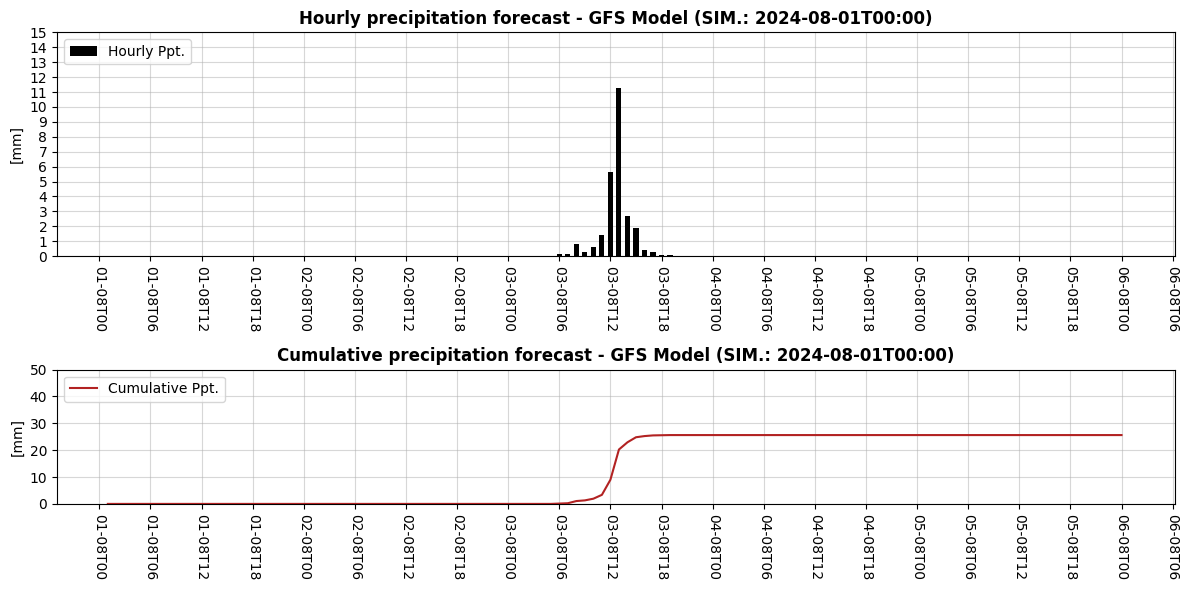

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={"height_ratios" : [1, .6]}, sharex=True)

ax[0].bar(DF_01.index, DF_01["PPT_D"], label="Hourly Ppt.", color="black", zorder=5, width=.025)
ax[0].set_title(f"Hourly precipitation forecast - GFS Model (SIM.: {DATE_START})", fontweight="bold")

# Set y range and ticks
ax[0].set_ylim(0, 15)
ax[0].yaxis.set_ticks(np.arange(0, 15+1, 1))

ax[1].plot(DF_01.index, DF_01["CUMSUM"], label="Cumulative Ppt.", color="firebrick", zorder=5)
ax[1].set_title(f"Cumulative precipitation forecast - GFS Model (SIM.: {DATE_START})", fontweight="bold")

# Set y range and ticks
ax[1].set_ylim(0, 50)
ax[1].yaxis.set_ticks(np.arange(0, 50+10, 10))

# Figure settings along both axis
for i in [0, 1]:

  ax[i].set_ylabel("[mm]")
  ax[i].legend(loc="upper left")
  ax[i].grid(alpha=.5)
  ax[i].tick_params(labelbottom=True)
  ax[i].tick_params(axis="both", which="major")
  DATE_FMT = mdates.DateFormatter('%d-%mT%H')
  ax[i].xaxis.set_major_formatter(DATE_FMT)
  ax[i].xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
  ax[i].tick_params(axis="x", labelrotation=-90)

fig.tight_layout()
plt.show();

In [14]:
# Create an image that's the cumulated precipitation for the entire period.
DS_02 = DS_01["CUMSUM"].isel(FyH=-1) - DS_01["CUMSUM"].isel(FyH=0)

DS_02

<xarray.DataArray 'CUMSUM' (lon: 14, lat: 11)>
array([[10.875 , 10.    , 11.6875, 15.125 , 16.5   , 17.5625, 15.5625,
        12.875 , 11.8125,  7.    ,  3.4375],
       [11.3125, 11.75  , 10.5625, 12.5625, 16.5625, 16.5625, 16.9375,
        14.1875, 12.3125,  9.75  ,  5.375 ],
       [11.0625, 12.3125, 11.6875, 11.5625, 16.25  , 20.3125, 18.75  ,
        18.625 , 15.625 , 13.875 ,  8.125 ],
       [11.75  , 14.125 , 15.6875, 14.8125, 16.75  , 22.75  , 23.125 ,
        20.875 , 22.    , 21.1875, 16.4375],
       [13.8125, 16.9375, 18.25  , 20.0625, 19.8125, 21.5625, 27.0625,
        23.0625, 21.625 , 23.25  , 23.5625],
       [13.4375, 20.3125, 21.5   , 22.875 , 23.8125, 23.1875, 25.125 ,
        27.    , 26.375 , 23.375 , 22.8125],
       [ 8.4375, 14.25  , 22.    , 26.5   , 26.0625, 25.625 , 28.0625,
        30.25  , 26.9375, 25.25  , 21.875 ],
       [ 8.8125,  9.3125, 12.6875, 19.6875, 27.75  , 28.9375, 28.5625,
        32.8125, 31.0625, 29.75  , 25.4375],
       [ 8.1875, 11.375 , 10.75  , 11.9375, 19.125 , 25.875 , 26.6875,
        28.0625, 31.5625, 31.5625, 30.625 ],
       [ 5.3125,  9.1875, 12.375 , 11.75  , 13.625 , 17.6875, 22.1875,
        24.6875, 28.625 , 31.6875, 28.5   ],
       [ 3.4375,  4.125 ,  8.625 , 13.    , 14.4375, 14.5   , 18.5   ,
        22.4375, 24.6875, 28.4375, 32.125 ],
       [ 2.75  ,  3.0625,  4.0625,  9.0625, 14.25  , 15.75  , 16.3125,
        19.125 , 22.1875, 24.0625, 31.3125],
       [ 1.4375,  2.3125,  2.5   ,  5.5625, 10.6875, 14.875 , 17.0625,
        18.    , 19.1875, 21.125 , 26.25  ],
       [ 1.125 ,  1.25  ,  1.75  ,  3.1875,  6.9375, 12.125 , 15.4375,
        17.8125, 17.8125, 18.125 , 22.4375]])
Coordinates:
  * lon      (lon) float32 -59.97 -59.72 -59.47 -59.22 ... -57.22 -56.97 -56.72
  * lat      (lat) float32 -33.24 -33.49 -33.74 -33.99 ... -35.24 -35.49 -35.74

In [15]:
# Create a geodataframe with the coordinates of the point of interest

# First we define a dataframe and then we turn it into a geodataframe

DF_POI = pd.DataFrame({'LON': [LON], 'LAT': [LAT]})

GDF_POI = gpd.GeoDataFrame(DF_POI, geometry=gpd.points_from_xy(DF_POI["LON"], DF_POI["LAT"]), crs="EPSG:4326").drop(columns=["LON", "LAT"])

GDF_POI

,geometry
0,POINT (-58.46633 -34.59960)


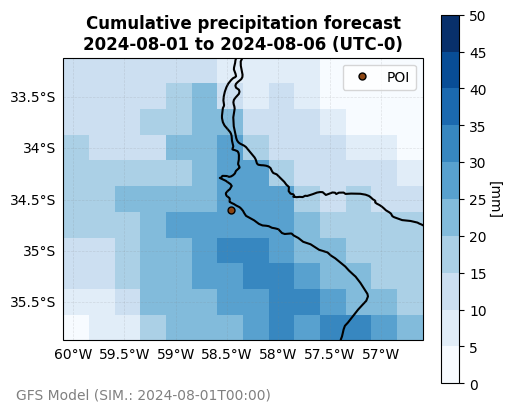

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

im =DS_02.plot(x="lon", y="lat", ax=ax, vmin=0, vmax=50, cmap="Blues", add_colorbar=False, levels=11)

# POI
ax.plot(GDF_POI.geometry.x, GDF_POI.geometry.y, 'o', color="saddlebrown", markersize=5, markeredgecolor="black", label="POI")

# Add a title to the whole figure
ax.set_title(f"Cumulative precipitation forecast\n{pd.to_datetime(DATE_START):%Y-%m-%d} to {(pd.to_datetime(DATE_START) + timedelta(days=5)):%Y-%m-%d} (UTC-0)", fontweight='bold')

# Add land boundaries
ax.add_feature(cf.COASTLINE, linewidth=1.5, edgecolor='black')

# Grid settings
GLs = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False,
                    linewidth=.5, color='gray', alpha=0.2, linestyle='--')

GLs.top_labels = False
GLs.right_labels = False

# Set x and y ticks at 1-degree intervals using MultipleLocator
GLs.xlocator = MultipleLocator(0.5)
GLs.ylocator = MultipleLocator(0.5)

# Create colorbar with specified ticks
cbar = fig.colorbar(im, ax=ax, shrink=0.75)
cbar.set_ticks(range(0, 50+5, 5))
cbar.set_label("[mm]", rotation=-90, labelpad=10)

# Legend
ax.legend(loc="upper right")

# Add a footnote to the bottom left corner
fig.text(0.02, 0.10, f"GFS Model (SIM.: {DATE_START})", color='gray')

plt.show();

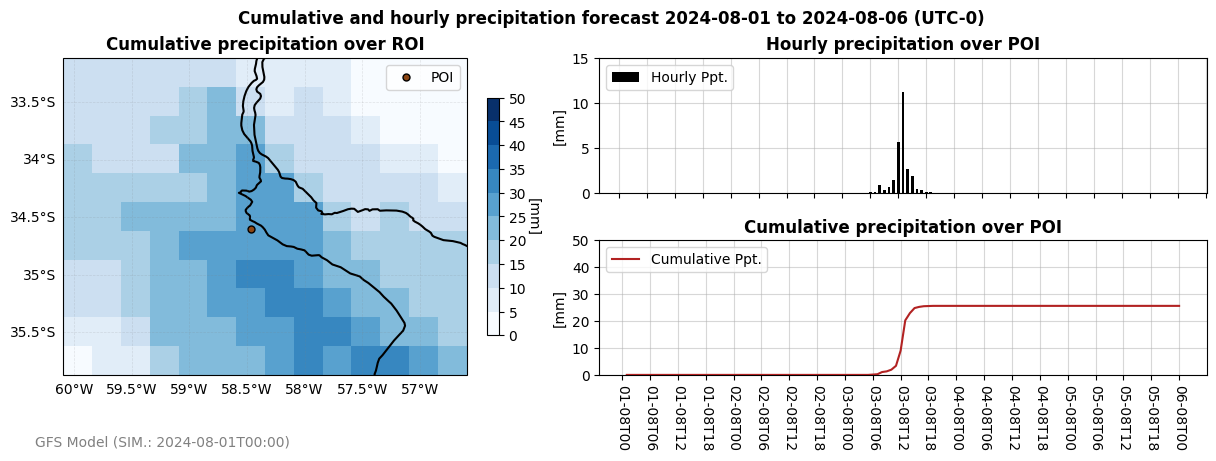

In [29]:
# Create the main plot using gridspec
fig = plt.figure(figsize=(12, 4.5), constrained_layout=True)

GS = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[.5, .75])

# Add a title to the whole figure
fig.suptitle(f"Cumulative and hourly precipitation forecast {pd.to_datetime(DATE_START):%Y-%m-%d} to {(pd.to_datetime(DATE_START) + timedelta(days=5)):%Y-%m-%d} (UTC-0)", fontweight='bold')

# MAP
ax_0 = fig.add_subplot(GS[:, 0], projection=ccrs.PlateCarree())

# ROI
im =DS_02.plot(x="lon", y="lat", ax=ax_0, vmin=0, vmax=50, cmap="Blues", add_colorbar=False, levels=11)

# POI
ax_0.plot(GDF_POI.geometry.x, GDF_POI.geometry.y, 'o', color="saddlebrown", markersize=5, markeredgecolor="black", label="POI")

ax_0.set_title(f"Cumulative precipitation over ROI", fontweight="bold")

# Add land boundaries
ax_0.add_feature(cf.COASTLINE, linewidth=1.5, edgecolor='black')

# Grid settings
GLs = ax_0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False,
                    linewidth=.5, color='gray', alpha=0.2, linestyle='--')

# Visibility
GLs.top_labels = False
GLs.right_labels = False

# Set x and y ticks at 1-degree intervals using MultipleLocator
GLs.xlocator = MultipleLocator(0.5)
GLs.ylocator = MultipleLocator(0.5)

# Create colorbar with specified ticks
cbar = fig.colorbar(im, ax=ax_0, shrink=0.75)
cbar.set_ticks(range(0, 50+5, 5))
cbar.set_label("[mm]", rotation=-90, labelpad=10)

# Legend
ax_0.legend(loc="upper right")

# Discrete Ppt
ax_1 = fig.add_subplot(GS[0, 1])

ax_1.bar(DF_01.index, DF_01["PPT_D"], label="Hourly Ppt.", color="black", zorder=5, width=.025)

ax_1.set_title(f"Hourly precipitation over POI", fontweight="bold")

# Set y range and ticks
ax_1.set_ylim(0, 15)
ax_1.yaxis.set_ticks(np.arange(0, 15+5, 5))

# Set x ticks to false
ax_1.tick_params(labelbottom=False)

# Cumulative Ppt
ax_2 = fig.add_subplot(GS[1, 1])

ax_2.plot(DF_01.index, DF_01["CUMSUM"], label="Cumulative Ppt.", color="firebrick", zorder=5)
ax_2.set_title(f"Cumulative precipitation over POI", fontweight="bold")

# Set y range and ticks
ax_2.set_ylim(0, 50)
ax_2.yaxis.set_ticks(np.arange(0, 50+10, 10))

ax_2.tick_params(labelbottom=True)
DATE_FMT = mdates.DateFormatter('%d-%mT%H')
ax_2.xaxis.set_major_formatter(DATE_FMT)
ax_2.xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
ax_2.tick_params(axis="x", labelrotation=-90)

# Common properties
for ax in [ax_1, ax_2]:

    ax.set_ylabel("[mm]")
    ax.legend(loc="upper left")
    ax.grid(alpha=.5)
    ax.tick_params(axis="both", which="major")
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))

# Add a footnote to the bottom left corner
fig.text(0.02, 0.02, f"GFS Model (SIM.: {DATE_START})", color='gray')


plt.show();